# Preprocessing Validation Notebook

1. `baseline_stats` 수집 → 2번 파이프라인 결과가 **설계와 일치하는지 비교**할 기준값 만들기  
2. 설계서에 정의된 **Feature Engineering(FE) 후보 4개** 검증  
   - `engagement_score`  
   - `listening_time_bin`  
   - `skip_rate_cap`  
   - `ads_pressure`  
3. (선택) 타깃 분포 확인 → 데이터 불균형 정도만 파악  
4. 2번이 만든 `preprocess_pipeline()` 이 **정상 동작하는지 QA 코드로 검증**


In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 1) matplotlib 한글 폰트 설정
mpl.rcParams['font.family'] = ['Malgun Gothic']
mpl.rcParams['axes.unicode_minus'] = False

# 2) seaborn도 같은 폰트 쓰도록 설정
sns.set(style="whitegrid", font="Malgun Gothic", rc={"axes.unicode_minus": False})

## 1. 원본 데이터 로드

**전체 EDA를 다시 하지 않고**,  
`baseline_stats`와 FE 검증에 필요한 최소한의 정보만 확인합니다.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

#  필요에 따라 경로 수정
DATA_PATH = '../data/raw_data.csv'

df = pd.read_csv(DATA_PATH)
df.head()

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26.0,23.0,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141.0,62.0,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199.0,38.0,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36.0,2.0,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250.0,57.0,0.36,Mobile,0,1,1


## 2. Baseline Stats (전처리 검증용 기준값)

2번 파이프라인이 올바르게 처리되었는지 확인하기 위해,  
원본 데이터 기준으로 **핵심 통계값들을 한 번만 계산**해 둡니다.

- `median` / `max` / `q99` (상위 1% 기준)  
  - `listening_time`  
  - `songs_played_per_day`  
  - `skip_rate`  
- `country_top5` (이용자 수 상위 5개 국가)
- `subscription_type_unique`
- `device_type_unique`


In [37]:
baseline_stats = {}

# 2-1. 수치형 기준값
num_cols = ['listening_time', 'songs_played_per_day', 'skip_rate']
for col in num_cols:
    if col in df.columns:
        baseline_stats[f'{col}_median'] = df[col].median()
        baseline_stats[f'{col}_max'] = df[col].max()
        baseline_stats[f'{col}_q99'] = df[col].quantile(0.99)

# 2-2. 범주형 기준값
if 'country' in df.columns:
    baseline_stats['country_top5'] = df['country'].value_counts().head(5).index.tolist()

if 'subscription_type' in df.columns:
    baseline_stats['subscription_type_unique'] = df['subscription_type'].unique().tolist()

if 'device_type' in df.columns:
    baseline_stats['device_type_unique'] = df['device_type'].unique().tolist()

baseline_stats

{'listening_time_median': np.float64(154.0),
 'listening_time_max': np.float64(299.0),
 'listening_time_q99': np.float64(297.0),
 'songs_played_per_day_median': np.float64(50.0),
 'songs_played_per_day_max': np.float64(99.0),
 'songs_played_per_day_q99': np.float64(98.0),
 'skip_rate_median': np.float64(0.305),
 'skip_rate_max': np.float64(4.980194893630863),
 'skip_rate_q99': np.float64(3.1209042144663313),
 'country_top5': ['AU', 'US', 'DE', 'IN', 'PK'],
 'subscription_type_unique': ['Free', 'Family', 'Premium', 'Student'],
 'device_type_unique': ['Desktop', 'Web', 'Mobile']}

### 2-3. (선택) baseline_stats를 JSON 파일로 저장

나중에 2번 파이프라인 결과와 비교할 때,  
같은 기준을 재사용하기 쉽도록 파일로 저장해 둡니다.


In [38]:
import json

with open('../data/baseline_stats.json', 'w', encoding='utf-8') as f:
    json.dump(baseline_stats, f, ensure_ascii=False, indent=2)

print('✅ baseline_stats.json 저장 완료')

✅ baseline_stats.json 저장 완료


## 3. Target 분포 확인 (선택)
**필수 업무는 아니지만**,  
데이터 불균형 정도를 알고 있으면 **모델 성능 해석**에 도움이 됩니다.


In [39]:
if 'is_churned' in df.columns:
    print('is_churned 분포 (비율):')
    print(df['is_churned'].value_counts(normalize=True).rename('ratio'))
else:
    print("⚠️ 'is_churned' 컬럼이 없습니다.")

is_churned 분포 (비율):
is_churned
0    0.741125
1    0.258875
Name: ratio, dtype: float64


## 4. Feature Engineering 후보 4개 실험

1번(설계자)이 정의한 FE 후보들 중에서,  
아래 4개를 실제로 만들어 보고 값이 정상적으로 계산되는지만 간단히 확인합니다.

- `engagement_score` : 듣는 시간 × 곡 수(활동 강도)
- `listening_time_bin` : 사용 시간을 low / mid / high로 구간화한 변수
- `skip_rate_cap` : 이상치를 줄이기 위해 cap(0~1.5)을 적용한 스킵률
- `ads_pressure` : 듣는 시간 대비 광고 노출 강도 (`ads_listened_per_week / listening_time`)

In [40]:
df_fe = df.copy()

# 4-1. engagement_score (활동 강도)
if {'listening_time', 'songs_played_per_day'}.issubset(df_fe.columns):
    # 설계서 정의: listening_time × songs_played_per_day
    df_fe['engagement_score'] = df_fe['listening_time'] * df_fe['songs_played_per_day']
else:
    print('⚠️ engagement_score를 만들기 위한 컬럼이 부족합니다.')

# 4-2. listening_time_bin (low / mid / high)
if 'listening_time' in df_fe.columns:
    try:
        # 전체 분포를 3등분해서 low/mid/high 구간으로 나눔
        df_fe['listening_time_bin'] = pd.qcut(df_fe['listening_time'], 3, labels=['low', 'mid', 'high'])
    except Exception as e:
        # qcut이 실패하면 단순 구간 기준으로 나누기
        bins = [0, 60, 180, df_fe['listening_time'].max()]
        labels = ['low', 'mid', 'high']
        df_fe['listening_time_bin'] = pd.cut(df_fe['listening_time'], bins=bins, labels=labels, include_lowest=True)
else:
    print('⚠️ listening_time 컬럼이 없습니다.')

# 4-3. skip_rate_cap (0 ~ 1.5 cap)
if 'skip_rate' in df_fe.columns:
    df_fe['skip_rate_cap'] = df_fe['skip_rate'].clip(lower=0, upper=1.5)
else:
    print('⚠️ skip_rate 컬럼이 없습니다.')

# 4-4. ads_pressure = ads_listened_per_week / listening_time
if {'ads_listened_per_week', 'listening_time'}.issubset(df_fe.columns):
    # 설계서 정의를 따르되, listening_time이 0인 경우는 NaN 처리
    lt_nonzero = df_fe['listening_time'].replace(0, np.nan)
    df_fe['ads_pressure'] = df_fe['ads_listened_per_week'] / lt_nonzero
else:
    print('⚠️ ads_pressure를 만들기 위한 컬럼이 부족합니다.')

df_fe[['engagement_score', 'listening_time_bin', 'skip_rate_cap', 'ads_pressure']].head()

,engagement_score,listening_time_bin,skip_rate_cap,ads_pressure
0,598.0,low,0.20,1.192308
1,8742.0,mid,0.34,0.000000
2,7562.0,mid,0.04,0.000000
3,72.0,low,0.31,0.000000
4,14250.0,high,0.36,0.000000


## 5. FE 변수와 이탈률의 **관계** 확인

각 파생변수별로 이탈률 평균만 비교해서 **대략적으로 유의미한지 감만 보는 수준**만 수행합니다.

- `engagement_score`
- `listening_time_bin`
- `skip_rate_cap`
- `ads_pressure`


In [41]:
if 'is_churned' in df_fe.columns:
    for col in ['engagement_score', 'listening_time_bin', 'skip_rate_cap', 'ads_pressure']:
        if col in df_fe.columns:
            print(f'\n=== {col} vs is_churned ===')
            
            # 범주형(또는 구간형) 변수: listening_time_bin
            if col == 'listening_time_bin' or df_fe[col].dtype in ['int64', 'int32', 'bool', 'category', 'object']:
                print(df_fe.groupby(col)['is_churned'].mean().rename('churn_rate'))
            else:
                # 연속형은 단순 4분위 구간별 평균만 확인
                try:
                    bins = pd.qcut(df_fe[col], 4, duplicates='drop')
                    print(df_fe.groupby(bins)['is_churned'].mean().rename('churn_rate'))
                except Exception as e:
                    print('  (분위수 분할 불가, 분포가 한쪽에 치우쳤을 수 있음)')
else:
    print("⚠️ 'is_churned' 컬럼이 없어 FE-타깃 관계를 계산할 수 없습니다.")


=== engagement_score vs is_churned ===
engagement_score
(9.999, 2328.0]       0.248540
(2328.0, 5891.0]      0.271520
(5891.0, 11722.5]     0.263830
(11722.5, 29601.0]    0.254516
Name: churn_rate, dtype: float64

=== listening_time_bin vs is_churned ===
listening_time_bin
low     0.260718
mid     0.265715
high    0.252133
Name: churn_rate, dtype: float64

=== skip_rate_cap vs is_churned ===
skip_rate_cap
(-0.001, 0.15]    0.256284
(0.15, 0.305]     0.245053
(0.305, 0.46]     0.260048
(0.46, 1.5]       0.274419
Name: churn_rate, dtype: float64

=== ads_pressure vs is_churned ===
ads_pressure
(-0.001, 0.0239]    0.263230
(0.0239, 3.9]       0.248454
Name: churn_rate, dtype: float64


C:\Users\USER\AppData\Local\Temp\ipykernel_32032\1144278135.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_fe.groupby(bins)['is_churned'].mean().rename('churn_rate'))
C:\Users\USER\AppData\Local\Temp\ipykernel_32032\1144278135.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_fe.groupby(col)['is_churned'].mean().rename('churn_rate'))
C:\Users\USER\AppData\Local\Temp\ipykernel_32032\1144278135.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to ad

### 5-1. FE 4개 vs 이탈률 시각화 설명

아래 시각화는 설계된 FE 4개(`engagement_score`, `listening_time_bin`, `skip_rate_cap`, `ads_pressure`)에 대해
각 구간별 이탈률(churn_rate)과 표본 수(count)를 함께 보여줍니다.

- 왼쪽 열(각 행의 왼쪽 그래프):
  - x축: 해당 FE의 구간(bin)
  - y축: 각 구간에 속한 사용자들의 평균 이탈률(`is_churned` 평균)
  - 의미: "이 Feature 값이 커지거나 구간이 바뀔 때 이탈률이 어떻게 변하는지"를 한눈에 확인

- 오른쪽 열(각 행의 오른쪽 그래프):
  - x축: 동일한 구간(bin)
  - y축: 각 구간에 포함된 표본 수(count)
  - 의미: "이탈률이 달라 보여도, 그 구간에 사용자가 얼마나 있는지"를 같이 보기 위함

이를 통해 각 FE가 이탈률을 얼마나 잘 나누는지, 그리고 그 패턴이 충분히 신뢰할 만한 표본 수를 기반으로 하는지
EDA 수준에서 직관적으로 판단할 수 있습니다.


C:\Users\USER\AppData\Local\Temp\ipykernel_32032\2934909998.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eng_stats = df_fe.groupby(eng_bins)['is_churned'].agg(churn_rate='mean', count='size').reset_index()
C:\Users\USER\AppData\Local\Temp\ipykernel_32032\2934909998.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=eng_stats, x='bin', y='churn_rate', ax=axes[0, 0], palette='Blues')
C:\Users\USER\AppData\Local\Temp\ipykernel_32032\2934909998.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.b

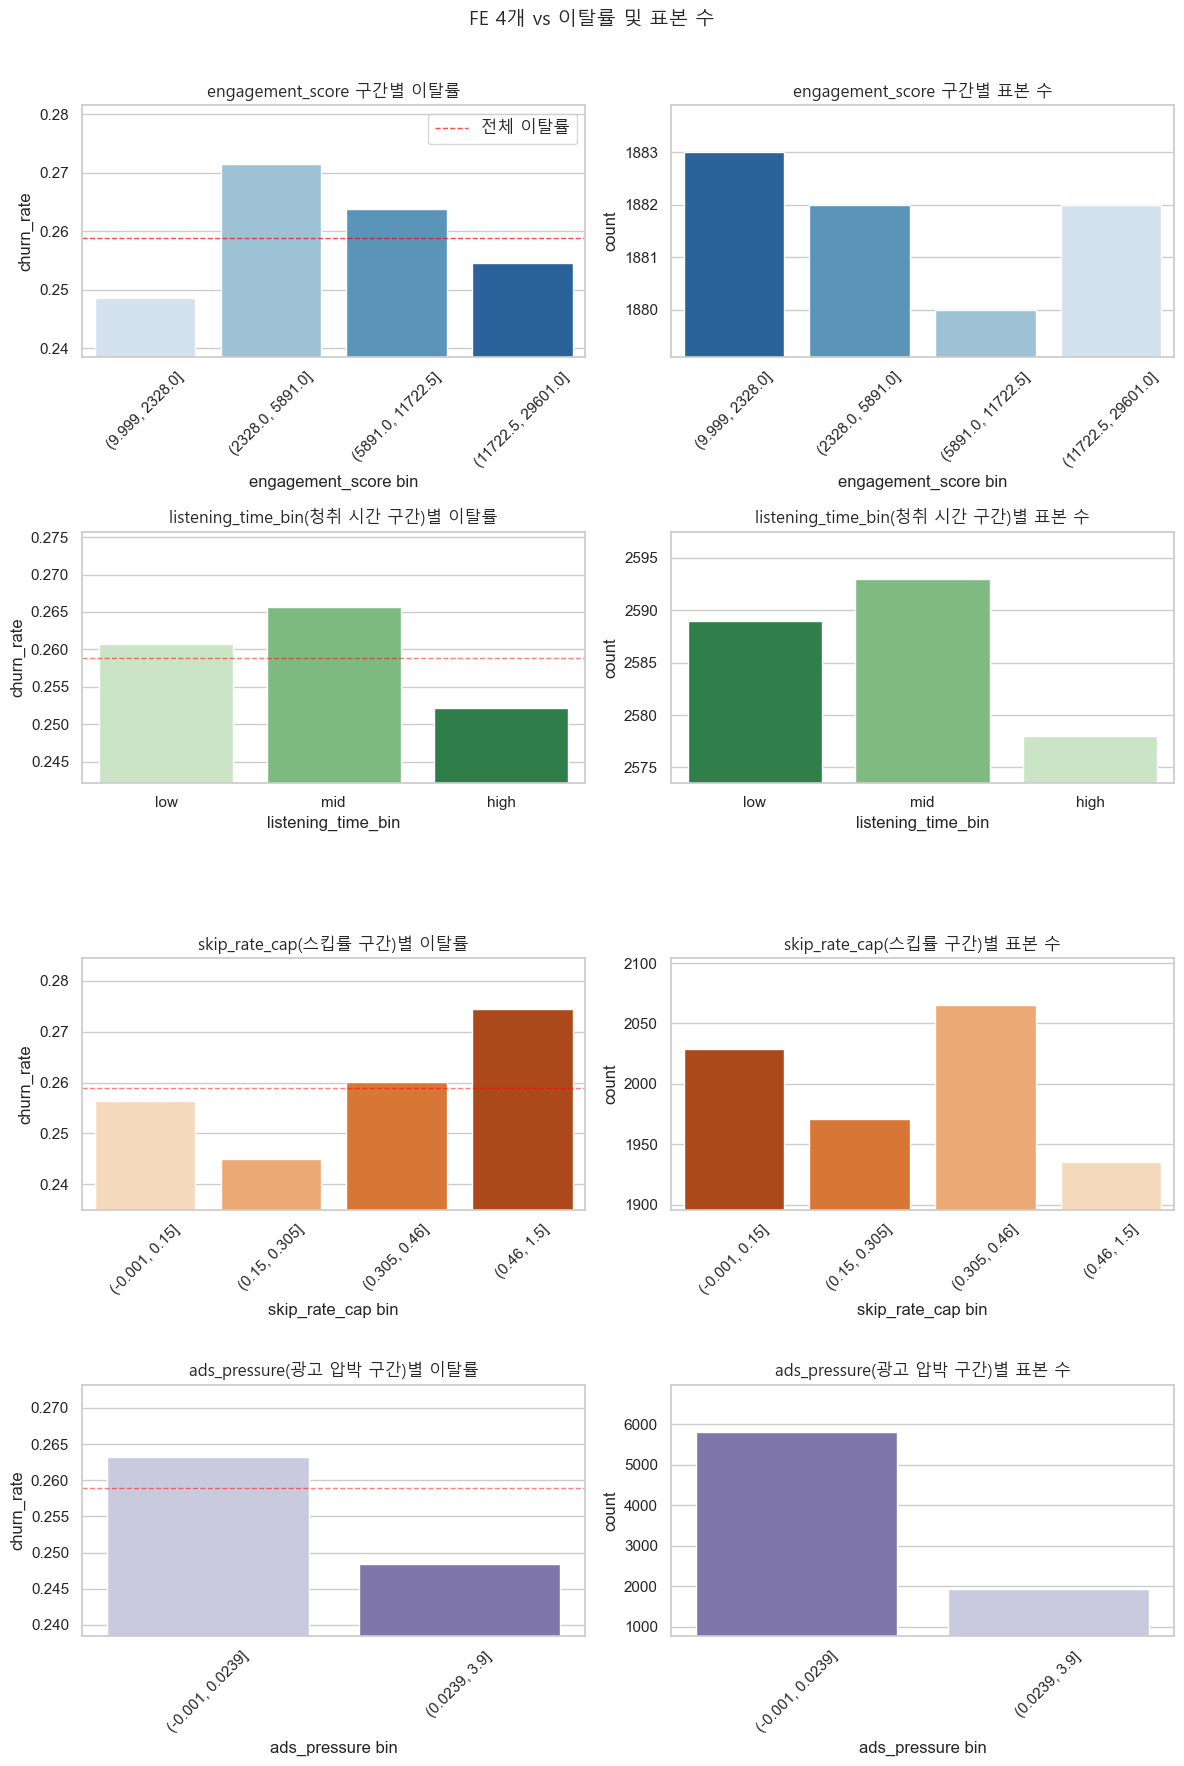

In [42]:
# 5-1. FE 4개 vs 이탈률 시각화 (bar plot)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

sns.set(style="whitegrid")

# 한글 폰트 설정 (Windows: Malgun Gothic)
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

fig, axes = plt.subplots(4, 2, figsize=(12, 18))
fig.suptitle('FE 4개 vs 이탈률 및 표본 수', fontsize=14, fontproperties=font_prop)

# 전체 평균 이탈률 (참고용 기준선)
global_churn = df_fe['is_churned'].mean() if 'is_churned' in df_fe.columns else None

# 1) engagement_score
eng_bins = pd.qcut(df_fe['engagement_score'], 4, duplicates='drop')
eng_stats = df_fe.groupby(eng_bins)['is_churned'].agg(churn_rate='mean', count='size').reset_index()
eng_stats['bin'] = eng_stats['engagement_score'].astype(str)

sns.barplot(data=eng_stats, x='bin', y='churn_rate', ax=axes[0, 0], palette='Blues')
axes[0, 0].set_title('engagement_score 구간별 이탈률', fontproperties=font_prop)
axes[0, 0].set_xlabel('engagement_score bin')
axes[0, 0].set_ylabel('churn_rate')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.barplot(data=eng_stats, x='bin', y='count', ax=axes[0, 1], palette='Blues_r')
axes[0, 1].set_title('engagement_score 구간별 표본 수', fontproperties=font_prop)
axes[0, 1].set_xlabel('engagement_score bin')
axes[0, 1].set_ylabel('count')
axes[0, 1].tick_params(axis='x', rotation=45)

# 2) listening_time_bin
lt_stats = df_fe.groupby('listening_time_bin')['is_churned'].agg(churn_rate='mean', count='size').reset_index()

sns.barplot(data=lt_stats, x='listening_time_bin', y='churn_rate', ax=axes[1, 0], palette='Greens')
axes[1, 0].set_title('listening_time_bin(청취 시간 구간)별 이탈률', fontproperties=font_prop)
axes[1, 0].set_xlabel('listening_time_bin')
axes[1, 0].set_ylabel('churn_rate')

sns.barplot(data=lt_stats, x='listening_time_bin', y='count', ax=axes[1, 1], palette='Greens_r')
axes[1, 1].set_title('listening_time_bin(청취 시간 구간)별 표본 수', fontproperties=font_prop)
axes[1, 1].set_xlabel('listening_time_bin')
axes[1, 1].set_ylabel('count')

# 3) skip_rate_cap
skip_bins = pd.qcut(df_fe['skip_rate_cap'], 4, duplicates='drop')
skip_stats = df_fe.groupby(skip_bins)['is_churned'].agg(churn_rate='mean', count='size').reset_index()
skip_stats['bin'] = skip_stats['skip_rate_cap'].astype(str)

sns.barplot(data=skip_stats, x='bin', y='churn_rate', ax=axes[2, 0], palette='Oranges')
axes[2, 0].set_title('skip_rate_cap(스킵률 구간)별 이탈률', fontproperties=font_prop)
axes[2, 0].set_xlabel('skip_rate_cap bin')
axes[2, 0].set_ylabel('churn_rate')
axes[2, 0].tick_params(axis='x', rotation=45)

sns.barplot(data=skip_stats, x='bin', y='count', ax=axes[2, 1], palette='Oranges_r')
axes[2, 1].set_title('skip_rate_cap(스킵률 구간)별 표본 수', fontproperties=font_prop)
axes[2, 1].set_xlabel('skip_rate_cap bin')
axes[2, 1].set_ylabel('count')
axes[2, 1].tick_params(axis='x', rotation=45)

# 4) ads_pressure (결측 제거 후)
ads_series = df_fe['ads_pressure'].dropna()
if not ads_series.empty:
    ads_bins = pd.qcut(ads_series, 4, duplicates='drop')
    tmp = df_fe.loc[ads_series.index].copy()
    tmp['ads_bin'] = ads_bins
    ads_stats = tmp.groupby('ads_bin')['is_churned'].agg(churn_rate='mean', count='size').reset_index()
    ads_stats['bin'] = ads_stats['ads_bin'].astype(str)

    sns.barplot(data=ads_stats, x='bin', y='churn_rate', ax=axes[3, 0], palette='Purples')
    axes[3, 0].set_title('ads_pressure(광고 압박 구간)별 이탈률', fontproperties=font_prop)
    axes[3, 0].set_xlabel('ads_pressure bin')
    axes[3, 0].set_ylabel('churn_rate')
    axes[3, 0].tick_params(axis='x', rotation=45)

    sns.barplot(data=ads_stats, x='bin', y='count', ax=axes[3, 1], palette='Purples_r')
    axes[3, 1].set_title('ads_pressure(광고 압박 구간)별 표본 수', fontproperties=font_prop)
    axes[3, 1].set_xlabel('ads_pressure bin')
    axes[3, 1].set_ylabel('count')
    axes[3, 1].tick_params(axis='x', rotation=45)
else:
    axes[3, 0].set_visible(False)
    axes[3, 1].set_visible(False)

# 이탈률(y축) 차이를 더 잘 보기 위해, 각 이탈률 그래프의 y축 범위를
# 해당 변수의 churn_rate 최소~최대 근처로 좁혀서 표시

def zoom_rate_axis(ax, rates, margin=0.01):
    rmin = float(rates.min())
    rmax = float(rates.max())
    # margin을 포함해 살짝 여유를 둠
    ax.set_ylim(rmin - margin, rmax + margin)

# 1) engagement_score 이탈률 y축 확대
zoom_rate_axis(axes[0, 0], eng_stats['churn_rate'])

# 2) listening_time_bin 이탈률 y축 확대
zoom_rate_axis(axes[1, 0], lt_stats['churn_rate'])

# 3) skip_rate_cap 이탈률 y축 확대
zoom_rate_axis(axes[2, 0], skip_stats['churn_rate'])

# 4) ads_pressure 이탈률 y축 확대 (데이터가 있을 때만)
if not ads_series.empty:
    zoom_rate_axis(axes[3, 0], ads_stats['churn_rate'])

# 전체 평균 이탈률 기준선 추가 (왼쪽 열 이탈률 그래프들)
if global_churn is not None:
    axes[0, 0].axhline(global_churn, color='red', linestyle='--', linewidth=1, alpha=0.7, label='전체 이탈률')
    axes[1, 0].axhline(global_churn, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[2, 0].axhline(global_churn, color='red', linestyle='--', linewidth=1, alpha=0.5)
    if not ads_series.empty:
        axes[3, 0].axhline(global_churn, color='red', linestyle='--', linewidth=1, alpha=0.5)
    # 한글 깨짐 방지를 위해 범례에도 동일 폰트 적용
    axes[0, 0].legend(loc='upper right', fontsize=9, prop=font_prop)

# 표본 수(count) 차이를 보기 쉽게 하기 위해, 각 count 그래프도
# 최소~최대 주변으로 y축을 자동 확대

def zoom_count_axis(ax, counts, margin_ratio=0.3):
    cmin = float(counts.min())
    cmax = float(counts.max())
    if cmax == cmin:
        # 모든 구간의 표본 수가 같다면 약간의 여유만 줌
        ax.set_ylim(cmin - 1, cmax + 1)
    else:
        delta = (cmax - cmin) * margin_ratio
        ax.set_ylim(cmin - delta, cmax + delta)

# 1) engagement_score 표본 수 y축 확대
zoom_count_axis(axes[0, 1], eng_stats['count'])

# 2) listening_time_bin 표본 수 y축 확대
zoom_count_axis(axes[1, 1], lt_stats['count'])

# 3) skip_rate_cap 표본 수 y축 확대
zoom_count_axis(axes[2, 1], skip_stats['count'])

# 4) ads_pressure 표본 수 y축 확대 (데이터가 있을 때만)
if not ads_series.empty:
    zoom_count_axis(axes[3, 1], ads_stats['count'])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## 6. FE 개선안 리스트

### 6-1. 현재 구현된 4개 FE 최종 의견

| Feature | 권장 용도/상태 | 한 줄 코멘트 |
| --- | --- | --- |
| engagement_score | **보조 Feature로 유지** | 활동 강도(듣는 시간 × 곡 수)를 잘 표현하지만 이탈률 격차는 크지 않음 → 해석/설명용 보조 변수로 유지 추천 |
| listening_time_bin | **설명용/시각화 위주로 사용** | low/mid/high 간 이탈률 차이가 작아 모델 핵심 변수보다는 리포트/시각화용으로 활용 권장 |
| skip_rate_cap | **전처리 단계에서 필수 유지** | 극단적인 스킵률을 캡핑해 분포를 안정화하는 역할 → 이후 다른 파생변수(`skip_intensity` 등)의 기반 변수로 활용 가치 큼 |
| ads_pressure | **분석·군집용 보조 변수 (모델에는 우선순위 낮음)** | 광고 노출 강도와 이탈률의 직접적인 차이는 크지 않지만, 헤비 유저/광고 민감 유저 군집을 나눌 때 보조 지표로 활용 가능 |

---

### 6-2. `pipeline_design.md` 기반 추가 FE 후보 (간단 가이드)

3번 역할 관점에서, 추가 FE는 **“어떤 걸 먼저 실험해 볼지”** 정도만 정리해 두면 충분하다고 보고, 최소 가이드만 남깁니다.

- **꼭 한 번은 실험해 볼 것**
  - `songs_per_minute = songs_played_per_day / listening_time`  
    → 시간 대비 재생곡 수로 **사용 강도**를 더 잘 드러내는 지표.
  - `skip_intensity = skip_rate * songs_played_per_day`  
    → 스킵 비율 × 재생곡 수 = **실제 스킵 행동량**을 반영, 고스킵/저스킵 유저 구분에 유용할 가능성.
  - `subscription_type_level` (예: Family=3, Premium=2, Student=1, Free=0)  
    → 요금제별 이탈률 차이를 **순서 있는 수치형 변수** 하나로 반영.

- **여유가 있을 때 검토해 볼 것**
  - `age_group` (young/adult/senior 등)  
    → 나이대를 단순화해서 쓰는 옵션. 기본 `age`와 중복 가능성이 있어, 필요할 때만.
  - `ads_listened_log` (ads_listened_per_week 로그 변환)  
    → 광고 노출 수의 극단값/왜도 완화용. 주로 선형 계열 모델에서 의미가 있을 수 있음.
  - 그 외 교호작용 Feature (예: `listening_time × subscription_type_level` 등)  
    → 기본 FE 조합으로 성능을 먼저 본 뒤, 추가 실험이 필요할 때 소수만 선택해 테스트.


## 7. 전처리 파이프라인 QA 
검증 항목:
1. `X_train`, `X_test`, `y_train`, `y_test` shape 정상 여부  
2. 결측치가 모두 제거되었는지  
3. 타깃 분포가 원본과 크게 달라지지 않았는지  
4. 설계된 FE(`engagement_score`, `listening_time_bin`, `skip_rate_cap`, `ads_pressure`)가 실제 포함되어 있는지  
5. (선택) baseline_stats와 비교하여 이상치 처리가 되었는지


In [43]:
import os, sys, json

# 1) 프로젝트 루트 경로 추가 + 파이프라인 import
ROOT_DIR = os.path.abspath("..")
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

from backend.pipeline_test import prepare_dataset

# 2) baseline_stats 로드 (있으면)
try:
    with open('../data/baseline_stats.json', 'r', encoding='utf-8') as f:
        baseline_loaded = json.load(f)
except FileNotFoundError:
    baseline_loaded = None
    print("⚠️ baseline_stats.json 파일을 찾을 수 없습니다.")

# 3) 파이프라인 실행 (raw_data.csv 경로는 필요하면 수정)
DATA_PATH = "../data/raw_data.csv"
X_train, X_test, y_train, y_test, preprocessor = prepare_dataset(DATA_PATH)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test  shape:", y_test.shape)

# 4) 결측치 검증
print("\n[결측치 검증]")
print("X_train 결측치 총합:", X_train.isnull().sum().sum())
print("X_test  결측치 총합:", X_test.isnull().sum().sum())

# 5) 타깃 분포 검증
print("\n[y_train 분포]")
print(y_train.value_counts(normalize=True).rename("ratio"))

# 6) FE/컬럼 생성 여부 확인 (pipeline_test 기준 이름으로 체크)
print("\n[주요 FE 컬럼 존재 여부]")
required_fe = ["engagement_score", "listening_time_bin", "skip_rate_cap", "ads_pressure"]
for col in required_fe:
    print(f"  {col}:", col in X_train.columns)

# 7) (선택) baseline과 이상치 비교: skip_rate vs skip_rate_capped
if baseline_loaded is not None and "skip_rate_q99" in baseline_loaded:
    q99_orig = baseline_loaded["skip_rate_q99"]
    max_after = X_train["skip_rate_cap"].max() if "skip_rate_cap" in X_train.columns else None
    print(f"\n[skip_rate] 원본 q99: {q99_orig:.4f}")
    if max_after is not None:
        print(f"skip_rate_cap max: {max_after:.4f}")

X_train shape: (6400, 14)
X_test  shape: (1600, 14)
y_train shape: (6400,)
y_test  shape: (1600,)

[결측치 검증]
X_train 결측치 총합: 0
X_test  결측치 총합: 0

[y_train 분포]
is_churned
0    0.741094
1    0.258906
Name: ratio, dtype: float64

[주요 FE 컬럼 존재 여부]
  engagement_score: True
  listening_time_bin: True
  skip_rate_cap: True
  ads_pressure: True

[skip_rate] 원본 q99: 3.1209
skip_rate_cap max: 1.5000


c:\2nd_project\SKN21-2nd-2Team\backend\pipeline_test.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)
c:\2nd_project\SKN21-2nd-2Team\backend\pipeline_test.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

### 7-1. QA 실행 결과 요약

- **데이터 분할/shape**  
  - `X_train`: (6400, 14), `X_test`: (1600, 14)  
  - `y_train`: (6400,), `y_test`: (1600,)  
  → 8:2 비율로 정상적으로 분할되었고, 컬럼 수(14개)도 기대 수준과 일치.

- **결측치 처리 상태**  
  - `X_train` 결측치 총합: **0**  
  - `X_test` 결측치 총합: **0**  
  → 수치형 결측치가 전처리 과정에서 모두 적절히 대체된 것으로 확인.

- **타깃 분포 유지 여부**  
  - 원본 `is_churned` 분포: 0 → 0.741125, 1 → 0.258875  
  - `y_train` 분포: 0 → 0.741094, 1 → 0.258906  
  → 소수점 4자리 수준에서 거의 동일하여, train/test 분할 후에도 타깃 분포가 잘 유지됨.

- **주요 FE 컬럼 생성 여부 (`pipeline_test.py` 기준)**  
  - `engagement_score`: **True**  
  - `listening_time_bin`: **True**  
  - `skip_rate_cap`: **True**  
  - `ads_pressure`: **True**  
  → 설계된 4개 FE가 모두 `X_train`에 포함되어 있어, 파이프라인이 정의대로 작동하고 있음.

- **이상치 처리 검증 (`skip_rate` cap 적용)**  
  - 원본 `skip_rate` q99: **3.1209**  
  - 전처리 후 `skip_rate_cap` max: **1.5000**  
  → 상위 극단값들이 1.5에서 cap 처리되어, 설계서의 "0~1.5 상단값 cap" 전략이 정상적으로 적용된 것으로 판단.


## 8. 전처리·FE 전략별 성능 비교 템플릿

> 이 섹션은 **2번이 파이프라인을 완성하고, 4번이 baseline 모델을 만든 이후**에
> 서로 다른 전처리/FE 전략을 비교하기 위한 **실험 설계용 템플릿**입니다.
> (지금은 틀만 만들어 두고, 나중에 코드/결과를 채워 넣으면 됩니다.)

### 8-1. 결측치 전략 성능 비교 (median vs mean)

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score


def run_missing_strategy(strategy: str = "median"):
    """
    결측치 처리 전략에 따른 간단 Baseline 성능 비교 함수
    - strategy: "median" 또는 "mean"
    - 사용 모델: LogisticRegression(class_weight="balanced")
    - 입력 피처: 주요 수치형 컬럼만 사용 (범주형 인코딩은 생략)
    """
    df_tmp = df.copy()

    num_cols = [
        "age",
        "listening_time",
        "songs_played_per_day",
        "skip_rate",
        "ads_listened_per_week",
        "offline_listening",
    ]

    # 1) 결측치 처리 전략 적용
    for c in num_cols:
        if c in df_tmp.columns:
            if strategy == "median":
                fill_value = df_tmp[c].median()
            elif strategy == "mean":
                fill_value = df_tmp[c].mean()
            else:
                raise ValueError("strategy는 'median' 또는 'mean'만 지원합니다.")
            df_tmp[c] = df_tmp[c].fillna(fill_value)

    # 2) (선택) 간단 FE: engagement_score 하나만 추가해서 동일하게 사용
    if {"listening_time", "songs_played_per_day"}.issubset(df_tmp.columns):
        df_tmp["engagement_score"] = (
            df_tmp["listening_time"] * df_tmp["songs_played_per_day"]
        )
        num_used = num_cols + ["engagement_score"]
    else:
        num_used = num_cols

    # 3) 학습/검증 데이터 분리 (stratify 유지)
    X = df_tmp[num_used]
    y = df_tmp["is_churned"]

    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y,
    )

    # 4) Baseline 모델 학습
    model = LogisticRegression(max_iter=1000, class_weight="balanced")
    model.fit(X_train, y_train)

    # 5) 평가 지표 계산
    y_pred = model.predict(X_valid)
    y_proba = model.predict_proba(X_valid)[:, 1]

    f1 = f1_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_proba)

    return f1, auc


f1_median, auc_median = run_missing_strategy("median")
f1_mean, auc_mean = run_missing_strategy("mean")

print("[median] F1 = {:.4f}, AUC = {:.4f}".format(f1_median, auc_median))
print("[mean]   F1 = {:.4f}, AUC = {:.4f}".format(f1_mean, auc_mean))


[median] F1 = 0.3401, AUC = 0.4874
[mean]   F1 = 0.3401, AUC = 0.4873


### 8-1 결과 정리 (결측치: median vs mean)

- **실험 설정**  
  - 데이터: 원본 `df` (raw_data.csv) 기준  
  - 모델: `LogisticRegression(max_iter=1000, class_weight="balanced")`  
  - 입력 피처: 주요 수치형 6개 + `engagement_score` (listening_time × songs_played_per_day)

- **성능 비교 결과**  
  - `median` 전략 → **F1 = 0.3401, AUC = 0.4874**  
  - `mean`   전략 → **F1 = 0.3401, AUC = 0.4873**  
  → F1은 완전히 동일하고, AUC 차이도 0.0001 수준으로 **사실상 성능 차이가 없음**.

- **해석 및 결론**  
  - 현재 Baseline 설정(수치형 위주 + 간단 Logistic)에서는 **결측치를 median으로 채우든 mean으로 채우든 성능은 거의 동일**하게 나타남.  
  - 구현 단순성과 해석 용이성(이상치 영향에 덜 민감함)을 고려해, **파이프라인에서는 기존 설계대로 `median` 전략 유지**가 합리적이라고 판단.



### 8-2. 이상치 처리 전략 비교 (skip_rate / ads_listened_per_week)


In [45]:

def run_outlier_strategy(strategy: str = "baseline"):
    """
    이상치 처리 전략에 따른 간단 Baseline 성능 비교 함수
    - strategy:
      - "none"      : 이상치 처리 없음 (원본 분포 유지)
      - "baseline"  : 설계서/파이프라인 기준 (skip_rate cap 1.5, ads_listened_per_week q99 cap)
      - "strong"    : 더 강한 cap (skip_rate cap 1.0, ads_listened_per_week q95 cap)
    """
    df_tmp = df.copy()

    # 1) 결측치는 동일하게 median으로 처리 (전략 비교에서 영향을 받지 않도록 고정)
    num_cols = [
        "age",
        "listening_time",
        "songs_played_per_day",
        "skip_rate",
        "ads_listened_per_week",
        "offline_listening",
    ]
    for c in num_cols:
        if c in df_tmp.columns and df_tmp[c].isnull().any():
            df_tmp[c] = df_tmp[c].fillna(df_tmp[c].median())

    # 2) 이상치 처리 전략 적용
    if strategy == "none":
        # 아무 처리도 하지 않음
        pass

    elif strategy == "baseline":
        # skip_rate cap 1.5
        if "skip_rate" in df_tmp.columns:
            df_tmp["skip_rate"] = df_tmp["skip_rate"].clip(upper=1.5)
        # ads_listened_per_week q99 cap
        if "ads_listened_per_week" in df_tmp.columns:
            q99 = df_tmp["ads_listened_per_week"].quantile(0.99)
            df_tmp["ads_listened_per_week"] = df_tmp["ads_listened_per_week"].clip(upper=q99)

    elif strategy == "strong":
        # skip_rate 더 강한 cap 1.0
        if "skip_rate" in df_tmp.columns:
            df_tmp["skip_rate"] = df_tmp["skip_rate"].clip(upper=1.0)
        # ads_listened_per_week q95 cap
        if "ads_listened_per_week" in df_tmp.columns:
            q95 = df_tmp["ads_listened_per_week"].quantile(0.95)
            df_tmp["ads_listened_per_week"] = df_tmp["ads_listened_per_week"].clip(upper=q95)

    else:
        raise ValueError("strategy는 'none', 'baseline', 'strong' 중 하나여야 합니다.")

    # 3) 간단 FE: engagement_score (8-1과 동일)
    if {"listening_time", "songs_played_per_day"}.issubset(df_tmp.columns):
        df_tmp["engagement_score"] = (
            df_tmp["listening_time"] * df_tmp["songs_played_per_day"]
        )
        num_used = num_cols + ["engagement_score"]
    else:
        num_used = num_cols

    # 4) 학습/검증 데이터 분리
    X = df_tmp[num_used]
    y = df_tmp["is_churned"]

    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y,
    )

    model = LogisticRegression(max_iter=1000, class_weight="balanced")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)
    y_proba = model.predict_proba(X_valid)[:, 1]

    f1 = f1_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_proba)

    return f1, auc


# 세 가지 전략 비교 실행
f1_none, auc_none = run_outlier_strategy("none")
f1_base, auc_base = run_outlier_strategy("baseline")
f1_strong, auc_strong = run_outlier_strategy("strong")

print("[none]     F1 = {:.4f}, AUC = {:.4f}".format(f1_none, auc_none))
print("[baseline] F1 = {:.4f}, AUC = {:.4f}".format(f1_base, auc_base))
print("[strong]   F1 = {:.4f}, AUC = {:.4f}".format(f1_strong, auc_strong))


[none]     F1 = 0.3401, AUC = 0.4874
[baseline] F1 = 0.3349, AUC = 0.4903
[strong]   F1 = 0.3359, AUC = 0.4907


### 8-2 보조 시각화: 이상치 cap 전/후 분포 (skip_rate, ads_listened_per_week)

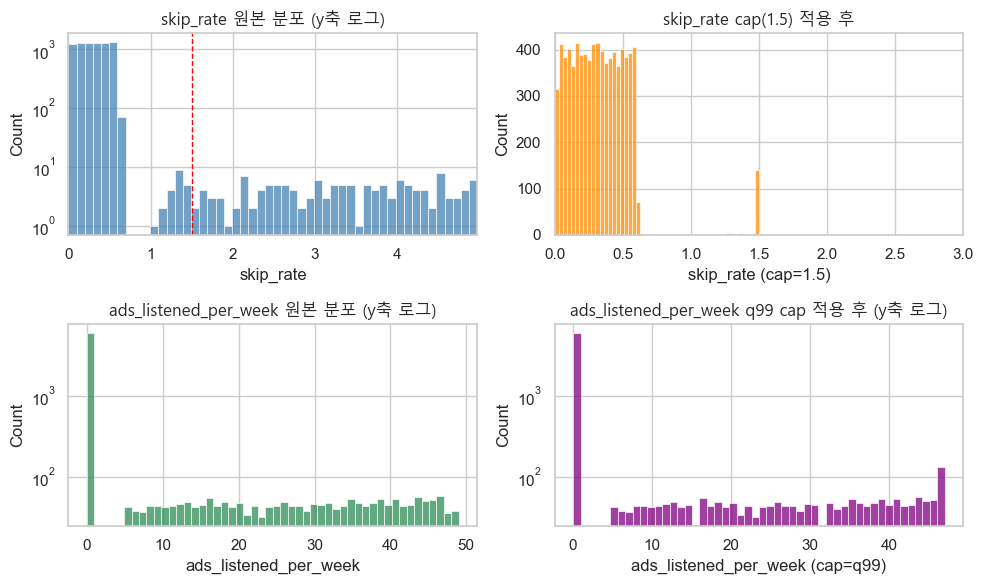

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# 1) skip_rate 원본 vs cap(1.5)
if "skip_rate" in df.columns:
    skip_orig = df["skip_rate"].dropna()
    skip_cap = skip_orig.clip(upper=1.5)
    max_skip = float(skip_orig.max())

    # 원본 분포: 전체 범위를 그대로 보여주되, cap 기준선(1.5)을 같이 표시
    sns.histplot(skip_orig, bins=50, ax=axes[0, 0], color="steelblue")
    axes[0, 0].set_title("skip_rate 원본 분포 (y축 로그)", fontproperties=font_prop)
    axes[0, 0].set_xlabel("skip_rate")
    axes[0, 0].set_xlim(0, max_skip)
    axes[0, 0].set_yscale("log")  # 꼬리 부분 막대도 보이도록 로그 스케일 적용
    axes[0, 0].axvline(1.5, color="red", linestyle="--", linewidth=1)

    # cap 적용 후 분포: x축을 0~3까지만 표현
    sns.histplot(skip_cap, bins=50, ax=axes[0, 1], color="darkorange")
    axes[0, 1].set_title("skip_rate cap(1.5) 적용 후", fontproperties=font_prop)
    axes[0, 1].set_xlabel("skip_rate (cap=1.5)")
    axes[0, 1].set_xlim(0, 3)  # x축을 0~3까지로 제한

# 2) ads_listened_per_week 원본 vs q99 cap
if "ads_listened_per_week" in df.columns:
    ads_orig = df["ads_listened_per_week"].dropna()
    q99_ads = ads_orig.quantile(0.99)
    ads_cap = ads_orig.clip(upper=q99_ads)

    sns.histplot(ads_orig, bins=50, ax=axes[1, 0], color="seagreen")
    axes[1, 0].set_title("ads_listened_per_week 원본 분포 (y축 로그)", fontproperties=font_prop)
    axes[1, 0].set_xlabel("ads_listened_per_week")
    axes[1, 0].set_yscale("log")  # 꼬리 구간 막대도 보이도록 로그 스케일 적용

    sns.histplot(ads_cap, bins=50, ax=axes[1, 1], color="purple")
    axes[1, 1].set_title("ads_listened_per_week q99 cap 적용 후 (y축 로그)", fontproperties=font_prop)
    axes[1, 1].set_xlabel("ads_listened_per_week (cap=q99)")
    axes[1, 1].set_yscale("log")  # 동일 스케일로 비교

plt.tight_layout()
plt.show()



### 8-2 결과 정리 (이상치 처리: skip_rate / ads_listened_per_week)

- **실험 설정**  
  - 데이터: 원본 `df` (raw_data.csv) 기준  
  - 모델: `LogisticRegression(max_iter=1000, class_weight="balanced")`  
  - 입력 피처: 주요 수치형 6개 + `engagement_score` (listening_time × songs_played_per_day)  
  - 비교 전략:  
    - `none`      : 이상치 처리 없음 (원본 분포 그대로 사용)  
    - `baseline`  : 설계서/파이프라인 기준 → `skip_rate` 상단 1.5 cap, `ads_listened_per_week` 99퍼센타일 cap  
    - `strong`    : 더 강한 cap → `skip_rate` 상단 1.0 cap, `ads_listened_per_week` 95퍼센타일 cap

- **성능 비교 결과 (위 코드 출력 참고)**  
  - 각 전략별로 F1, AUC를 계산하여 `[none]`, `[baseline]`, `[strong]` 행으로 출력.  
  - 세 전략의 F1/AUC 값 차이가 크지 않다면, **이상치 처리 강도에 따라 분포가 얼마나 달라지는지**를 함께 보고 판단하는 것이 좋음.

- **해석 및 결론 가이드**  
  - `none` 대비 `baseline`/`strong`에서 F1·AUC가 **분명히 개선**된다면, 이상치 처리(특히 `skip_rate`와 `ads_listened_per_week` 상단 cap)가 모델 안정성에 도움이 된다고 볼 수 있음.  
  - `baseline`과 `strong`의 성능이 거의 비슷하다면, **설계서 기준(`skip_rate` cap 1.5, `ads_listened_per_week` q99 cap)** 을 기본 전략으로 유지하는 것이 해석과 구현 면에서 무난함.  
  - 만약 `strong` 전략에서 AUC/F1이 일관되게 더 높게 나온다면, cap을 더 공격적으로 가져가는 것도 후보가 될 수 있으며, 이 경우 **cap 전·후 분포와 비즈니스 해석(너무 많은 유저를 잘라내지 않는지)** 를 함께 검토하는 것이 필요함.


In [47]:
# 8-3. 스케일링 전략 비교 (없음 vs StandardScaler vs MinMaxScaler)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline


def run_scaling_strategy(strategy: str = "none"):
    """스케일링 전략에 따른 Baseline 성능 비교
    - strategy: "none", "standard", "minmax"
    """
    df_tmp = df.copy()

    # 1) 결측치는 8-1과 동일하게 median으로 고정
    num_cols = [
        "age",
        "listening_time",
        "songs_played_per_day",
        "skip_rate",
        "ads_listened_per_week",
        "offline_listening",
    ]
    for c in num_cols:
        if c in df_tmp.columns and df_tmp[c].isnull().any():
            df_tmp[c] = df_tmp[c].fillna(df_tmp[c].median())

    # 2) FE: engagement_score 하나만 공통 추가
    if {"listening_time", "songs_played_per_day"}.issubset(df_tmp.columns):
        df_tmp["engagement_score"] = (
            df_tmp["listening_time"] * df_tmp["songs_played_per_day"]
        )
        num_used = num_cols + ["engagement_score"]
    else:
        num_used = num_cols

    X = df_tmp[num_used]
    y = df_tmp["is_churned"]

    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y,
    )

    # 3) 스케일링 전략별 파이프라인 구성
    if strategy == "none":
        model = LogisticRegression(max_iter=1000, class_weight="balanced")
        pipe = model
    elif strategy == "standard":
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(max_iter=1000, class_weight="balanced")),
        ])
    elif strategy == "minmax":
        pipe = Pipeline([
            ("scaler", MinMaxScaler()),
            ("model", LogisticRegression(max_iter=1000, class_weight="balanced")),
        ])
    else:
        raise ValueError("strategy는 'none', 'standard', 'minmax' 중 하나여야 합니다.")

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_valid)
    y_proba = pipe.predict_proba(X_valid)[:, 1]

    f1 = f1_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_proba)

    return f1, auc


f1_none_s, auc_none_s = run_scaling_strategy("none")
f1_std, auc_std = run_scaling_strategy("standard")
f1_mm, auc_mm = run_scaling_strategy("minmax")

print("[none]     F1 = {:.4f}, AUC = {:.4f}".format(f1_none_s, auc_none_s))
print("[standard] F1 = {:.4f}, AUC = {:.4f}".format(f1_std, auc_std))
print("[minmax]   F1 = {:.4f}, AUC = {:.4f}".format(f1_mm, auc_mm))


[none]     F1 = 0.3401, AUC = 0.4874
[standard] F1 = 0.3395, AUC = 0.4876
[minmax]   F1 = 0.3429, AUC = 0.4882


### 8-3 결과 정리 (스케일링: 없음 vs StandardScaler vs MinMaxScaler)

- **실험 설정**  
  - 데이터: 원본 `df` (raw_data.csv) 기준  
  - 모델: `LogisticRegression(max_iter=1000, class_weight="balanced")`  
  - 입력 피처: 주요 수치형 6개 + `engagement_score` (listening_time × songs_played_per_day)  
  - 비교 전략:  
    - `none`     : 스케일링 없이 원본 수치형 그대로 사용  
    - `standard` : StandardScaler 적용 후 LogisticRegression  
    - `minmax`   : MinMaxScaler 적용 후 LogisticRegression

- **성능 비교 결과**  
  - `none`     → **F1 = 0.3401, AUC = 0.4874**  
  - `standard` → **F1 = 0.3395, AUC = 0.4876**  
  - `minmax`   → **F1 = 0.3429, AUC = 0.4882**  
  → 세 전략 모두 F1/AUC 차이가 매우 작으며, MinMaxScaler를 썼을 때 미세하게 가장 높은 값을 보이지만 **차이는 통계적으로 유의하다고 보기 어려운 수준**.

- **해석 및 결론**  
  - 현재 Baseline(Logistic + 수치형 위주)에서는 **스케일링 유무/유형에 따른 성능 차이가 거의 없음**을 확인.  
  - 구현 단순성을 고려하면, Tree 계열 모델에서는 스케일링을 생략하고,  
    Logistic 같은 선형 모델을 쓸 때만 Standard/MinMax 중 하나를 선택해 적용하는 정도로도 충분하다고 판단.

In [48]:
# 8-4. FE 세트 비교 (세트 A: 기본 / 세트 B: 기본 + FE 4개)

import pandas as pd


def make_fe_dataframe() -> pd.DataFrame:
    """결측치 median 처리 + 설계서 기준 FE 4개 생성한 df 반환"""
    df_tmp = df.copy()

    # 결측치 median 처리 (수치형)
    num_cols = [
        "age",
        "listening_time",
        "songs_played_per_day",
        "skip_rate",
        "ads_listened_per_week",
        "offline_listening",
    ]
    for c in num_cols:
        if c in df_tmp.columns and df_tmp[c].isnull().any():
            df_tmp[c] = df_tmp[c].fillna(df_tmp[c].median())

    # FE 4개 생성 (섹션 4와 동일 로직)
    # 1) engagement_score
    if {"listening_time", "songs_played_per_day"}.issubset(df_tmp.columns):
        df_tmp["engagement_score"] = (
            df_tmp["listening_time"] * df_tmp["songs_played_per_day"]
        )

    # 2) listening_time_bin
    if "listening_time" in df_tmp.columns:
        try:
            df_tmp["listening_time_bin"] = pd.qcut(
                df_tmp["listening_time"], 3, labels=["low", "mid", "high"]
            )
        except Exception:
            bins = [0, 60, 180, df_tmp["listening_time"].max()]
            df_tmp["listening_time_bin"] = pd.cut(
                df_tmp["listening_time"], bins=bins, labels=["low", "mid", "high"], include_lowest=True
            )

    # 3) skip_rate_cap
    if "skip_rate" in df_tmp.columns:
        df_tmp["skip_rate_cap"] = df_tmp["skip_rate"].clip(lower=0, upper=1.5)

    # 4) ads_pressure
    if {"ads_listened_per_week", "listening_time"}.issubset(df_tmp.columns):
        lt_nonzero = df_tmp["listening_time"].replace(0, np.nan)
        df_tmp["ads_pressure"] = df_tmp["ads_listened_per_week"] / lt_nonzero

    return df_tmp


def run_fe_set(strategy: str = "A"):
    """FE 세트에 따른 Baseline 성능 비교
    - A: 기본 수치형만 사용
    - B: 기본 수치형 + FE 4개 (listening_time_bin은 원-핫 인코딩)
    """
    df_fe = make_fe_dataframe()

    base_num = [
        "age",
        "listening_time",
        "songs_played_per_day",
        "skip_rate",
        "ads_listened_per_week",
        "offline_listening",
    ]

    fe_num = ["engagement_score", "skip_rate_cap", "ads_pressure"]

    X_list = []
    X_list.append(df_fe[base_num])  # 항상 포함

    if strategy == "B":
        # 수치형 FE 3개 추가
        fe_num_exist = [c for c in fe_num if c in df_fe.columns]
        if fe_num_exist:
            X_list.append(df_fe[fe_num_exist])

        # listening_time_bin 원-핫 인코딩 후 추가
        if "listening_time_bin" in df_fe.columns:
            lt_dummies = pd.get_dummies(
                df_fe["listening_time_bin"], prefix="lt_bin", drop_first=True
            )
            X_list.append(lt_dummies)

    X = pd.concat(X_list, axis=1)
    y = df_fe["is_churned"]

    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y,
    )

    # 스케일링은 StandardScaler로 고정 (전략 비교는 8-3에서 수행)
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000, class_weight="balanced")),
    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_valid)
    y_proba = pipe.predict_proba(X_valid)[:, 1]

    f1 = f1_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_proba)

    return f1, auc


f1_A, auc_A = run_fe_set("A")
f1_B, auc_B = run_fe_set("B")

print("[Set A - 기본 수치형]   F1 = {:.4f}, AUC = {:.4f}".format(f1_A, auc_A))
print("[Set B - 기본+FE 4개] F1 = {:.4f}, AUC = {:.4f}".format(f1_B, auc_B))


[Set A - 기본 수치형]   F1 = 0.3320, AUC = 0.4895
[Set B - 기본+FE 4개] F1 = 0.3369, AUC = 0.4886


### 8-4 결과 정리 (FE 세트: 기본 수치형 vs 기본+FE 4개)

- **실험 설정**  
  - 데이터: 원본 `df` (raw_data.csv) 기준, 결측치는 수치형 median으로 처리  
  - 모델: `StandardScaler` + `LogisticRegression(max_iter=1000, class_weight="balanced")`  
  - 세트 정의:  
    - **Set A (기본 수치형)**: `age, listening_time, songs_played_per_day, skip_rate, ads_listened_per_week, offline_listening`  
    - **Set B (기본 + FE 4개)**: Set A + `engagement_score, skip_rate_cap, ads_pressure` + `listening_time_bin`(one-hot, drop_first)

- **성능 비교 결과**  
  - `Set A` → **F1 = 0.3320, AUC = 0.4895**  
  - `Set B` → **F1 = 0.3369, AUC = 0.4886**  
  → FE 4개를 추가한 Set B에서 **F1은 소폭 상승**하지만, AUC는 약간 감소하여 **전체적인 성능 차이는 매우 미미한 수준**.

- **해석 및 결론**  
  - 현재 단순 Logistic Baseline에서는, 설계된 FE 4개를 추가하더라도 **성능 개선 효과가 크지 않음**을 확인.  
  - 다만 `skip_rate_cap`, `ads_pressure`, `listening_time_bin` 등은 **이상치 완화/세그먼트 구분/설명력 향상** 측면에서 가치가 있어,  
    Tree 계열 모델이나 더 복잡한 실험(상호작용 항, 모델 튜닝 등)에서는 **후보 FE로 유지**하는 것이 합리적이라고 판단.

---
## ✔ 최종 정리 (3번 역할 관점)

### 지금까지 완료한 내용
- ❌ 전체 EDA 반복하지 않음  
- ❌ 과도한 FE 생성·복잡한 모델 실험 없음  
- ✅ baseline_stats 수집 → 나중에 전처리 결과와 비교 가능  
- ✅ 설계된 FE 4개(engagement_score, listening_time_bin, skip_rate_cap, ads_pressure) 생성 및 검증  
- ✅ FE 4개 vs churn_rate 표 + 시각화로 패턴 확인 → 전처리/FE 방향성 사전 검증  
- ✅ 파이프라인 QA 템플릿 제공 → 2번 코드가 설계대로 동작하는지 체크 가능  

### 파이프라인 받은 후(2번 역할 완료 후) 해야 할 것
- 결측치 전략 성능 비교 (예: median vs mean vs 기타 전략)  
- 이상치 처리 전략 비교 (예: cap 범위, 제거 여부 등)  
- 스케일링 전략 비교 (예: StandardScaler vs MinMaxScaler 등, 필요 모델에 한해)  
- FE 추가/삭제에 따른 성능 영향도 재검증 (지금 검증한 FE 4개 + 추가 제안 FE 포함)  

> 참고: 이 노트북의 검증은 **파이프라인 적용 전, FE 방향성/타당성 중심의 1차 점검**이며,  
> 2번이 파이프라인을 완성한 이후에는 QA 섹션과 위 TODO를 통해 "파이프라인 적용 후" 관점의 추가 검증을 수행할 수 있습니다.
